# What to classify ?

Lecture 3 : we saw the KNN algorithm to classify samples into classes. 

In our dataset, several electronic devices consume power. Each device is part of a category of devices :  
-multimedia = [computer, 3D_printer, internet_router, laptop, phone_charger, printer, screen, tv, sound_system],  
-kitchen = [boiler, coffee, freezer, fridge, micro_wave_oven],  
-cooling = [air_conditioner, fan],  
-other = [air_purifier, dehumidifier, radiator, solar_panel, vacuum].

Each category might have similar features, which could permit us to classify an unknown device. For example, in the category "washing", we expect all devices to be consuming power mainly during off-peak time, about once a week.

1-DIVIDE BY WEEKS EACH DEVICE so we get more data. Start on Monday at 00:00:01 for each device, each week. Create new files (save) so we don't have to compute the code all the time
Reduce the dimension of the files : time-stamp = 1min is enough

2-Compute relevant components  
Try to plot each component for each class to see if we can already see some differences between the classes, see if the components are relevant. Plot boxplot

3-Create X and Y : use the "plug_name" of the file "0_smart_plugs..."  

4- KNN on all the components (multiple dimensions KNN, more than  2 dim). Rescale
For the KNN : plot the accuracy, the graphs for different values of neighbors (see Lecture 3)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
import seaborn as sns

# 2- Relevant components

-maximum power  
-time of use  
-period of use
-used during the night or not : Louisa
-number of times used during a day : Louisa

In [2]:
# functions to extract the relevant components from a csv file file_device contain one week exactly from Monday 00:00:01 to the next Monday
#file device : path to the file, ex : household_power_consumption/solar_panel_325_1.csv

def max_power(file_device):
    "in : path to csv file, string"
    "out : maximum power consumed, float"
    "max_power different from the power max of the file 0, because the power is sumed to resample here"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    #df['time'] = df['timestamp'].dt.time

    max_power = df['power'].max()

    return max_power

    
def use_time(file_device):
    "in : path to csv file, string"
    "out : medium time of use per usage, float"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    df['time'] = df['timestamp'].dt.time

    time_use=0
    number_of_use=0
    in_functionment=False

    for i in df.index:
        if df['power'][i]!=0: 
            time_use+=1
        if not in_functionment and df['power'][i] >= 0:
            in_functionment = True
            number_of_use += 1
        elif in_functionment and df['power'][i] <= 0:
            in_functionment = False

    use_time=time_use/number_of_use

    return use_time

    
def period_use(file_device):
    "in : path to csv file, string"
    "out : when the device is used during the day, string"
    "compter le nombre de min par période ou l'appareil est utlisé"
    "diviser par la durée de chaque période, créer une dernière catégorie non classifié (qui pourrait correspondre à toute"
    "la journée ou à deux périodes d'utilisation...)"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    df['time'] = df['timestamp'].dt.time

    use_morning=0
    use_lunch=0
    use_afternoon=0
    use_evening=0
    use_night=0
    
    night_df = df[(df['time'] >= pd.to_datetime('22:00:00').time()) | (df['time'] < pd.to_datetime('06:00:00').time())]
    for i in night_df.index:
        use_night+=night_df['power'][i]
    use_night=use_night/(8*60)
        
    morning_df = df[(df['time'] >= pd.to_datetime('06:00:00').time()) | (df['time'] < pd.to_datetime('11:00:00').time())]
    for i in morning_df.index:
        use_morning+=morning_df['power'][i]
    use_morning=use_morning/(5*60)
    
    lunch_df = df[(df['time'] >= pd.to_datetime('11:00:00').time()) | (df['time'] < pd.to_datetime('13:30:00').time())]
    for i in lunch_df.index:
        use_lunch+=lunch_df['power'][i]
    use_lunch=use_lunch/(2.5*60)
    
    afternoon_df = df[(df['time'] >= pd.to_datetime('13:30:00').time()) | (df['time'] < pd.to_datetime('18:30:00').time())]
    for i in afternoon_df.index:
        use_afternoon+=afternoon_df['power'][i]
    use_afternoon=use_afternoon/(5*60)
    
    evening_df = df[(df['time'] >= pd.to_datetime('18:30:00').time()) | (df['time'] < pd.to_datetime('22:00:00').time())]
    for i in evening_df.index:
        use_evening+=evening_df['power'][i]
    use_evening=use_evening/(3.5*60)
    
    use_time=[use_morning,use_lunch,use_afternoon,use_evening,use_night]
    use_time_sorted=sorted(use_time, reverse=True)
    second_max=use_time_sorted[1]
    if use_morning==max(use_time) and second_max<0.8*max(use_time):
        return 1
    elif use_lunch==max(use_time) and second_max<0.8*max(use_time):
        return 2
    elif use_afternoon==max(use_time) and second_max<0.8*max(use_time):
        return 3
    elif use_evening==max(use_time) and second_max<0.8*max(use_time):
        return 4
    elif use_night==max(use_time) and second_max<0.8*max(use_time):
        return 5
    else : return 6 #non classified
    

def night(file_device):
    "in : path to csv file, string"
    "out : 1 or 0 : boolean if device is used during the night or not"
    "night : from 10pm to 6am"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    df['time'] = df['timestamp'].dt.time
    
    night_df = df[(df['time'] >= pd.to_datetime('22:00:00').time()) | (df['time'] < pd.to_datetime('06:00:00').time())]
    
    for i in night_df.index:
        #test : non zero value of the power during the night
        if df['power'][i]!=0: return 1
    
    return 0
    
    
    
def number_time(file_device):
    "in : path to csv file, string"
    "out :number of times the device was used during the week, int"
    "the device is used = period of time during which power !=0"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    df['time'] = df['timestamp'].dt.time
    
    number_used=0
    
    for i in df.index:
        if i==0 and df['power'][i]!=0:
            number_used+=1 
        elif df['power'][i]!=0 and df['power'][i-1]==0:
            number_used+=1
            
    return number_used

In [3]:
#Testing the functions of the relevant components with a csv file named test.csv, used two times and during the night

print(night("household_power_consumption/test.csv"))
print(number_time("household_power_consumption/test.csv"))
#ok, test passed

1
2


In [4]:
#function that takes device file and extract the relevant components

def components(file_device):
    "function that takes the 0_smart_plugs_devices.csv and a device csv file and extract the 5 relevant components"
    "file device : path to the file, ex : household_power_consumption/solar_panel_325_1.csv"
    "the file must contain one week exactly from Monday 00:00:01 to the next Monday"
    "out : array of size 5"
    
    compo=np.zeros(5)
    
    compo[0]=max_power(file_device)
    compo[1]=use_time(file_device)
    compo[2]=period_use(file_device)
    compo[3]=night(file_device)
    compo[4]=number_time(file_device)
    
    return compo
    

Plot the components for each category (by category and by object to see if the classification by objects is possible, just a visual checking) and do a box plot for each.

In [5]:
print(components('test.csv'))

[1.         0.22222222 2.         1.         2.        ]


# 3- KNN and classification

We now have the components that can distinguish two classes of devices. We perform the KNN algorithm to classify the devices.

0- X et y

In [6]:
%run name_and_cat.ipynb

X=[]
y=[]

directory = 'csv_files_1week'
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')] #select the csv files
 
for file in csv_files : #go through the csv_files
   print(file)
   compo=components(directory+'/'+file)
   X.append(compo)
   category=assign_type_and_group(file)
   type=category[0]
   y.append(type)


3D_printer_29_week_1_minutes.csv
3D_printer_29_week_2_minutes.csv
3D_printer_29_week_3_minutes.csv
air_conditioner_222_week_1_minutes.csv
air_conditioner_222_week_2_minutes.csv
air_conditioner_222_week_3_minutes.csv
air_purifier_293_week_1_minutes.csv
air_purifier_293_week_2_minutes.csv
air_purifier_293_week_3_minutes.csv
boiler_217_week_1_minutes.csv
boiler_217_week_2_minutes.csv
boiler_217_week_3_minutes.csv
boiler_226_week_1_minutes.csv
boiler_226_week_2_minutes.csv
boiler_226_week_3_minutes.csv
boiler_233_week_1_minutes.csv
boiler_233_week_2_minutes.csv
boiler_233_week_3_minutes.csv
boiler_233_week_4_minutes.csv
coffee_37_week_1_minutes.csv
coffee_37_week_2_minutes.csv
coffee_37_week_3_minutes.csv
coffee_54_week_1_minutes.csv
coffee_54_week_2_minutes.csv
coffee_54_week_3_minutes.csv
coffee_54_week_4_minutes.csv
coffee_97_week_1_minutes.csv
coffee_97_week_2_minutes.csv
coffee_97_week_3_minutes.csv
computer_44_week_1_minutes.csv
computer_44_week_2_minutes.csv
computer_44_week_3_minut

X[:,0]= [8.5205000e+03 8.7350000e+03 8.1275000e+03 1.4530000e+03 1.1555000e+03
 1.1405000e+03 3.5250000e+02 1.8000000e+02 1.8500000e+02 1.4908100e+05
 1.4852550e+05 1.4793050e+05 1.5541000e+05 1.5633050e+05 1.5673450e+05
 1.5347400e+05 1.5253300e+05 1.5215350e+05 1.5090600e+05 7.6983500e+04
 7.9651500e+04 7.7338000e+04 6.7126500e+04 6.0336500e+04 6.1968250e+04
 5.9395500e+04 1.0066750e+04 1.0101500e+04 8.9640000e+03 1.5353000e+04
 1.5921000e+04 1.3999000e+04 2.3140000e+04 2.2688500e+04 2.0972000e+04
 2.1327000e+04 2.8265000e+03 2.7880000e+03 2.7710000e+03 1.0618025e+05
 1.0655250e+05 1.0621000e+05 1.9117400e+05 1.9426700e+05 1.9183400e+05
 3.8080000e+03 4.1377500e+03 4.9537500e+03 9.5545000e+03 8.8260000e+03
 9.4725000e+03 1.0174500e+04 3.1831500e+04 1.0677000e+04 1.1449000e+04
 1.1256000e+04 1.1280000e+04 5.6770000e+03 5.8102500e+03 6.1152500e+03
 4.3370000e+04 4.4325000e+04 4.3925750e+04 6.0350000e+02 5.8100000e+02
 5.4300000e+02 2.0345000e+03 1.9360000e+03 1.9875000e+03 2.0630000e+0

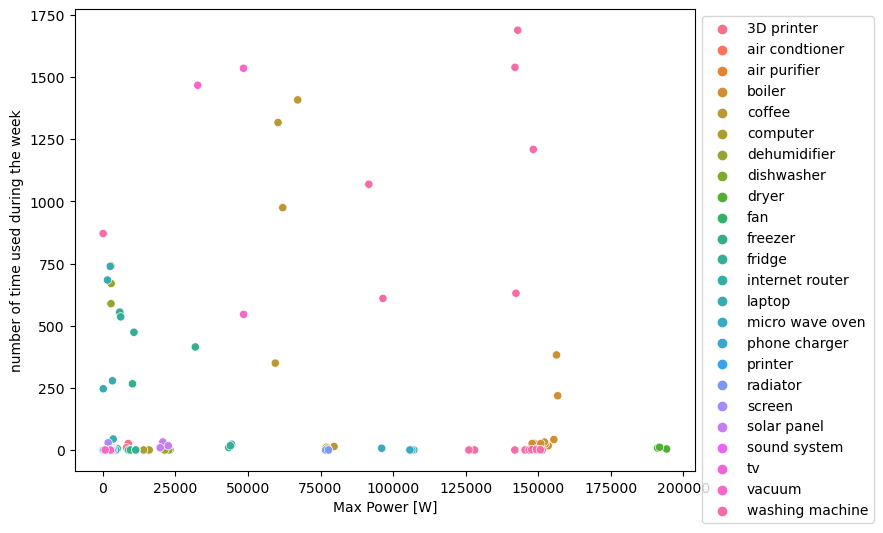

In [7]:
X=np.array(X)
y=np.array(y)

#print(X)
#print(y)

print('X[:,0]=',X[:,0])

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 4],hue=y)
plt.xlabel('Max Power [W]')
plt.ylabel('number of time used during the week')
#plt.title('PCA of Dataset')
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
plt.show()

1- Preprocess the data (transform in numeric data, normalize...)

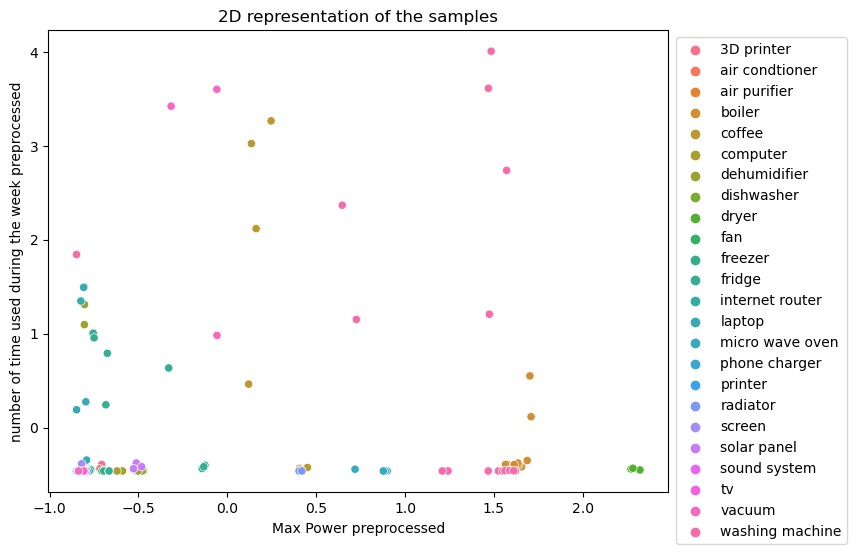

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#first_column = 1
#X=df.drop(df.columns[first_column], axis=1)
#y=df.iloc[:, first_column]

X=pd.DataFrame(X)

numerical_col=list(X.select_dtypes(include=['float64','int64']).columns)
categorical_col=list(X.select_dtypes(include=['object','bool']).columns)

ct = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_col),  
        ('cat', OneHotEncoder(), categorical_col)  
    ],
    remainder='passthrough')

X = ct.fit_transform(X)


plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 4],hue=y)
plt.xlabel('Max Power preprocessed')
plt.ylabel('number of time used during the week preprocessed')
plt.title('2D representation of the samples')
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
plt.show()

2- KNN

accuracy: 0.44


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\s

best cross-validation score: 0.627
best n_neighbors: 1
test-set score: 0.765


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


best mean cross-validation score: 0.698
best parameters: {'n_neighbors': 1}
test-set score: 0.794
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.001995      0.004629         0.002737        0.004478   
1       0.002700      0.004861         0.003224        0.004904   
2       0.002873      0.005273         0.002263        0.003643   
3       0.000247      0.000742         0.005679        0.007018   
4       0.000000      0.000000         0.001562        0.004686   
5       0.003683      0.006058         0.000757        0.001554   
6       0.000000      0.000000         0.007376        0.003817   

  param_n_neighbors               params  split0_test_score  \
0                 1   {'n_neighbors': 1}                0.7   
1                 3   {'n_neighbors': 3}                0.3   
2                 5   {'n_neighbors': 5}                0.3   
3                 7   {'n_neighbors': 7}                0.2   
4                 9   {'n_neighbors': 9}          

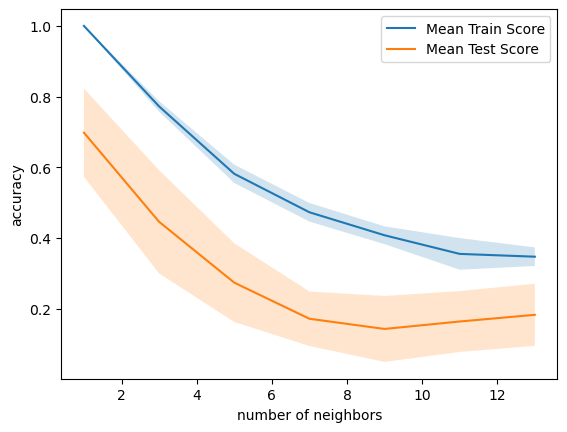

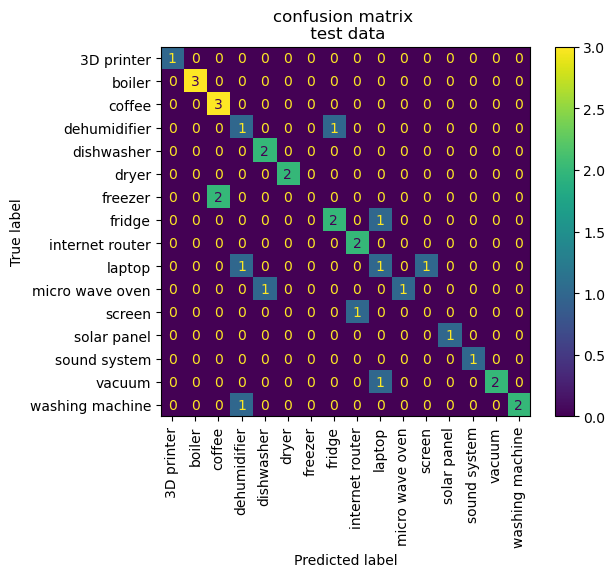

Class	 Sensitivity	 Specificity
3D printer	 1.00		 1.00
boiler	 1.00		 1.00
coffee	 1.00		 0.94
dehumidifier	 0.50		 0.94
dishwasher	 1.00		 0.97
dryer	 1.00		 1.00
freezer	 0.00		 1.00
fridge	 0.67		 0.97
internet router	 1.00		 0.97
laptop	 0.33		 0.94
micro wave oven	 0.50		 1.00
screen	 0.00		 0.97
solar panel	 1.00		 1.00
sound system	 1.00		 1.00
vacuum	 0.67		 1.00
washing machine	 0.67		 1.00


<Figure size 640x480 with 0 Axes>

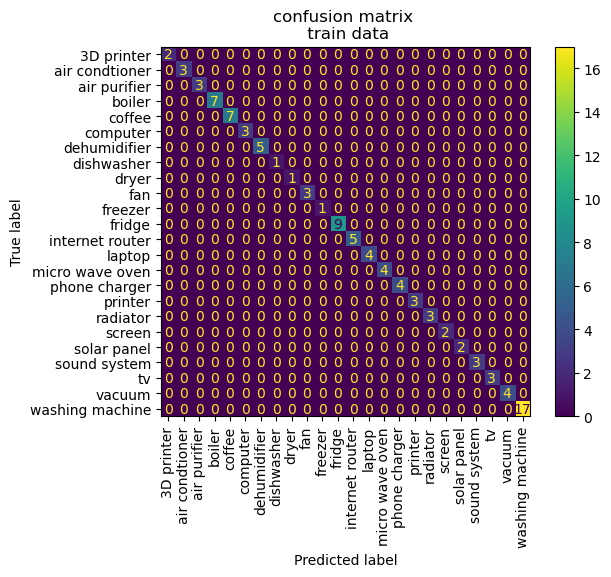

Class	 Sensitivity	 Specificity
3D printer	 1.00		 1.00
air condtioner	 1.00		 1.00
air purifier	 1.00		 0.94
boiler	 0.50		 0.94
coffee	 1.00		 0.97
computer	 1.00		 1.00
dehumidifier	 0.00		 1.00
dishwasher	 0.67		 0.97
dryer	 1.00		 0.97
fan	 0.33		 0.94
freezer	 0.50		 1.00
fridge	 0.00		 0.97
internet router	 1.00		 1.00
laptop	 1.00		 1.00
micro wave oven	 0.67		 1.00
phone charger	 0.67		 1.00


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#Simple knn

"X array of the form np.array([[x11,x12,x13,x14],...,[x_40_1,x_40_2,_40_3,_40_4]]) if 40 devices and 4 componenets to class them"
"Y array of the form np.array([y1,...,y40]) if 40 devices and 4 components to class them, with y1,...y40 is an int to indicate to which class the device belongs"

X_train, X_test, y_train, y_test = train_test_split(X, y)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("accuracy: {:.2f}".format(knn.score(X_test, y_test)))
    
    

    
#Model complexity

neighbors = range(1, 15, 2)

training_scores = []
test_scores = []
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

for n_neighbors in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    training_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))
    
#plt.figure()
#plt.plot(neighbors, training_scores, label="training scores")
#plt.plot(neighbors, test_scores, label="test scores")
#plt.ylabel("accuracy")
#plt.xlabel("n_neighbors")
#plt.legend()


#Improving the results : Cross validation

from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y)
cross_val_scores = []

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    cross_val_scores.append(np.mean(scores))
    
print("best cross-validation score: {:.3f}".format(np.max(cross_val_scores)))
best_n_neighbors = neighbors[np.argmax(cross_val_scores)]
print("best n_neighbors:", best_n_neighbors)

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)
print("test-set score: {:.3f}".format(knn.score(X_test, y_test)))


#Improving again the complexity of the model : GridSearchCV

from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

param_grid_knn = {'n_neighbors': np.arange(1, 15, 2)}

grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn,
                    cv=10, return_train_score=True)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

import pandas as pd
results = pd.DataFrame(grid.cv_results_)
print(results)

#ploting the results

plt.plot(results.param_n_neighbors.astype(int), results['mean_train_score'], label='Mean Train Score')
plt.plot(results.param_n_neighbors.astype(int), results['mean_test_score'], label='Mean Test Score')
plt.fill_between(results.param_n_neighbors.astype(int),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_n_neighbors.astype(int),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()
plt.xlabel('number of neighbors')
plt.ylabel('accuracy')


from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

print("accuracy: {:.2f}".format(knn.score(X_test, y_test)))

y_pred_test = knn.predict(X_test)
y_pred_train=knn.predict(X_train)

confusion_matrix_test = metrics.confusion_matrix(y_test, y_pred_test)
print(confusion_matrix_test.shape)
confusion_matrix_train = metrics.confusion_matrix(y_train, y_pred_train)

print("Confusion Matrix:")
print(confusion_matrix_test)

y_label = np.unique(np.concatenate((y_test, y_pred_test)))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test,display_labels=np.unique(y_label))
cm_display.plot()
plt.xticks(rotation=90)
plt.title('confusion matrix \n test data')
plt.show()

def calculate_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)

    for i in range(num_classes):
        true_positives = confusion_matrix[i, i]
        false_positives = np.sum(confusion_matrix[:, i]) - true_positives
        false_negatives = np.sum(confusion_matrix[i, :]) - true_positives

        sensitivity[i] = true_positives / (true_positives + false_negatives)
        true_negatives = np.sum(confusion_matrix) - true_positives - false_positives - false_negatives
        specificity[i] = true_negatives / (true_negatives + false_positives)

    return sensitivity, specificity

def display_metrics(sensitivity, specificity):
    print("Class\t Sensitivity\t Specificity")
    for i in range(len(sensitivity)):
        print(f"{y_label[i]}\t {sensitivity[i]:.2f}\t\t {specificity[i]:.2f}")
        
sensitivity, specificity = calculate_metrics(confusion_matrix_test)
display_metrics(sensitivity, specificity)

plt.figure()
y_label = np.unique(np.concatenate((y_train, y_pred_train)))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_train,display_labels=np.unique(y_label))
cm_display.plot()
plt.xticks(rotation=90)
plt.title('confusion matrix \n train data')
plt.show()



def calculate_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)

    for i in range(num_classes):
        true_positives = confusion_matrix[i, i]
        false_positives = np.sum(confusion_matrix[:, i]) - true_positives
        false_negatives = np.sum(confusion_matrix[i, :]) - true_positives

        sensitivity[i] = true_positives / (true_positives + false_negatives)
        true_negatives = np.sum(confusion_matrix) - true_positives - false_positives - false_negatives
        specificity[i] = true_negatives / (true_negatives + false_positives)

    return sensitivity, specificity

def display_metrics(sensitivity, specificity):
    print("Class\t Sensitivity\t Specificity")
    for i in range(len(sensitivity)):
        print(f"{y_label[i]}\t {sensitivity[i]:.2f}\t\t {specificity[i]:.2f}")
        
sensitivity, specificity = calculate_metrics(confusion_matrix_test)
display_metrics(sensitivity, specificity)

## KNN with only Max Power

3D_printer_29_week_1_minutes.csv
3D_printer_29_week_2_minutes.csv
3D_printer_29_week_3_minutes.csv
air_conditioner_222_week_1_minutes.csv
air_conditioner_222_week_2_minutes.csv
air_conditioner_222_week_3_minutes.csv
air_purifier_293_week_1_minutes.csv
air_purifier_293_week_2_minutes.csv
air_purifier_293_week_3_minutes.csv
boiler_217_week_1_minutes.csv
boiler_217_week_2_minutes.csv
boiler_217_week_3_minutes.csv
boiler_226_week_1_minutes.csv
boiler_226_week_2_minutes.csv
boiler_226_week_3_minutes.csv
boiler_233_week_1_minutes.csv
boiler_233_week_2_minutes.csv
boiler_233_week_3_minutes.csv
boiler_233_week_4_minutes.csv
coffee_37_week_1_minutes.csv
coffee_37_week_2_minutes.csv
coffee_37_week_3_minutes.csv
coffee_54_week_1_minutes.csv
coffee_54_week_2_minutes.csv
coffee_54_week_3_minutes.csv
coffee_54_week_4_minutes.csv
coffee_97_week_1_minutes.csv
coffee_97_week_2_minutes.csv
coffee_97_week_3_minutes.csv
computer_44_week_1_minutes.csv
computer_44_week_2_minutes.csv
computer_44_week_3_minut

c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\s

best cross-validation score: 0.646
best n_neighbors: 1
test-set score: 0.647
best mean cross-validation score: 0.586
best parameters: {'n_neighbors': 1}
test-set score: 0.647
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.000522      0.000980         0.000988        0.001988   
1       0.001796      0.004689         0.001253        0.003758   
2       0.000000      0.000000         0.004698        0.007177   
3       0.003028      0.006204         0.002906        0.005833   
4       0.000501      0.001502         0.007128        0.007160   
5       0.002758      0.004173         0.002463        0.004132   
6       0.001562      0.004687         0.004221        0.006279   

  param_n_neighbors               params  split0_test_score  \
0                 1   {'n_neighbors': 1}                0.6   
1                 3   {'n_neighbors': 3}                0.4   
2                 5   {'n_neighbors': 5}                0.5   
3                 7   {'n_neighbors'

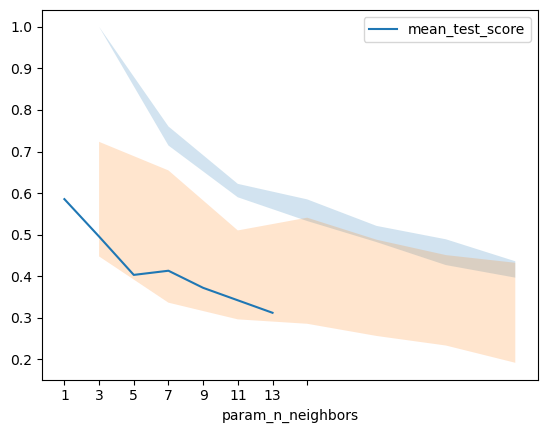

In [10]:
%run name_and_cat.ipynb

X_power=[]
y=[]

directory = 'csv_files_1week'
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')] #select the csv files
 
for file in csv_files : #go through the csv_files
   print(file)
   compo=components(directory+'/'+file)
   X_power.append(compo[0])
   category=assign_type_and_group(file)
   type=category[0]
   y.append(type)
   
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

X_power=pd.DataFrame(X_power)

numerical_col=list(X_power.select_dtypes(include=['float64','int64']).columns)
categorical_col=list(X_power.select_dtypes(include=['object','bool']).columns)

ct = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_col),  
        ('cat', OneHotEncoder(), categorical_col)  
    ],
    remainder='passthrough')

X_power = ct.fit_transform(X_power)

X_train, X_test, y_train, y_test = train_test_split(X_power, y)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("accuracy: {:.2f}".format(knn.score(X_test, y_test)))


#Improving the results : Cross validation

from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X_power, y)
cross_val_scores = []

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    cross_val_scores.append(np.mean(scores))
    
print("best cross-validation score: {:.3f}".format(np.max(cross_val_scores)))
best_n_neighbors = neighbors[np.argmax(cross_val_scores)]
print("best n_neighbors:", best_n_neighbors)

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)
print("test-set score: {:.3f}".format(knn.score(X_test, y_test)))



X_train, X_test, y_train, y_test = train_test_split(X_power, y, stratify=y, random_state=42)

param_grid_knn = {'n_neighbors': np.arange(1, 15, 2)}

grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn,
                    cv=10, return_train_score=True)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

import pandas as pd
results = pd.DataFrame(grid.cv_results_)
print(results)

#ploting the results

results.plot('param_n_neighbors', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_n_neighbors.astype(int),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_n_neighbors.astype(int),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

## PCA

Explained Variance Ratio: [0.33241267 0.27669831 0.19712034 0.11999582 0.07377286]


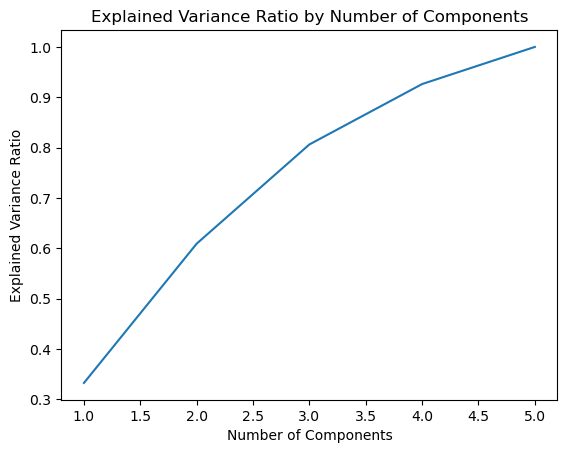

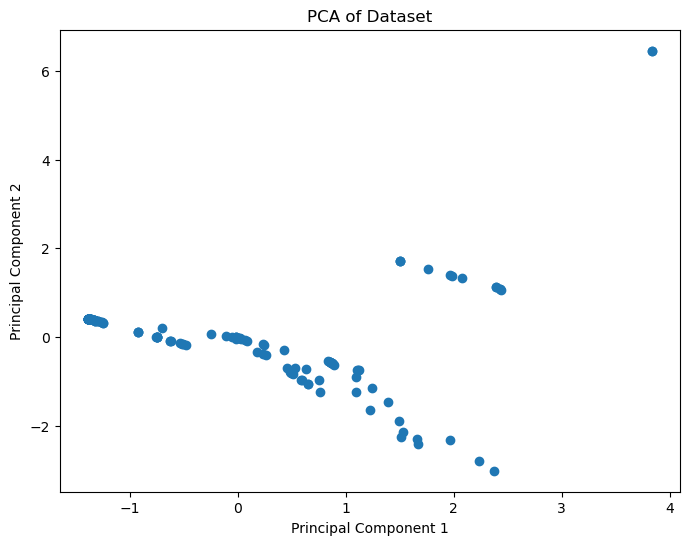

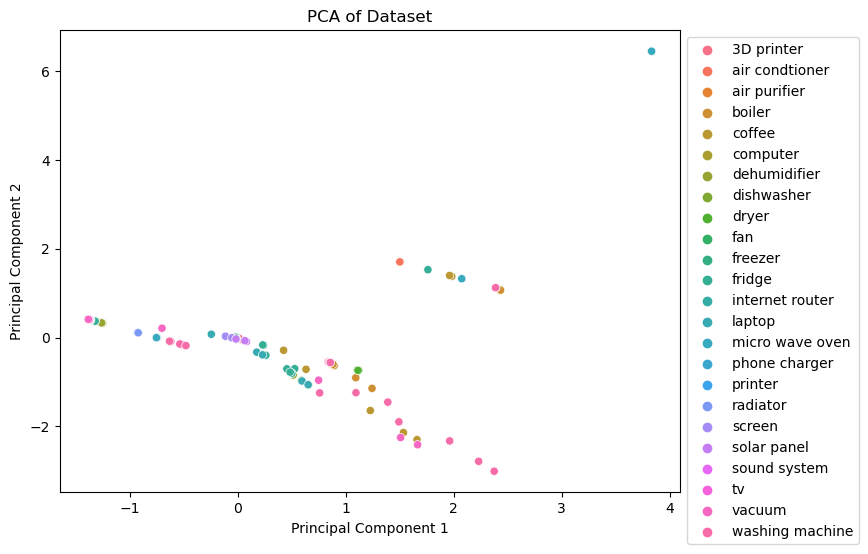

                  PC1       PC2       PC3
max_power    0.367531 -0.241094 -0.742609
use_time    -0.661871  0.188669 -0.117027
period_use   0.284972  0.576124  0.381954
night       -0.472231 -0.516022  0.189568
number_time  0.350196 -0.555049  0.503002


In [11]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
#print(X_pca)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Plot explained variance ratio
var = pca.explained_variance_ratio_
explained_var = np.cumsum(var)
plt.plot(range(1, len(var) + 1), explained_var)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Number of Components')
plt.show()

pca = PCA(n_components=3)  # Reduce to 3 components
X_pca = pca.fit_transform(X)
#print(X_pca)

# Scatter plot of first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],hue=y)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset')
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
plt.show()


loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'],index=['max_power', 'use_time','period_use','night','number_time'])
print(loadings)

#scores ?


Knn on PCA

c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\s

best cross-validation score: 0.657
best n_neighbors: 1
test-set score: 0.765
best mean cross-validation score: 0.698
best parameters: {'n_neighbors': 1}
test-set score: 0.794
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.001397      0.002524         0.002007        0.003399   
1       0.000484      0.001344         0.001455        0.002226   
2       0.000289      0.000598         0.001994        0.003284   
3       0.001549      0.002514         0.002654        0.003106   
4       0.001560      0.003084         0.004065        0.002106   
5       0.000150      0.000451         0.002091        0.002877   
6       0.000000      0.000000         0.001478        0.003128   

  param_n_neighbors               params  split0_test_score  \
0                 1   {'n_neighbors': 1}                0.7   
1                 3   {'n_neighbors': 3}                0.3   
2                 5   {'n_neighbors': 5}                0.3   
3                 7   {'n_neighbors'

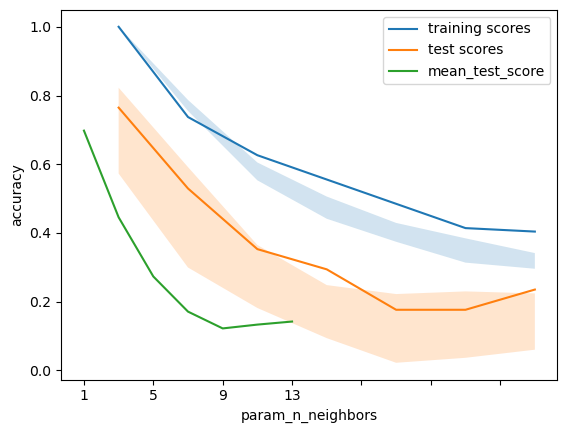

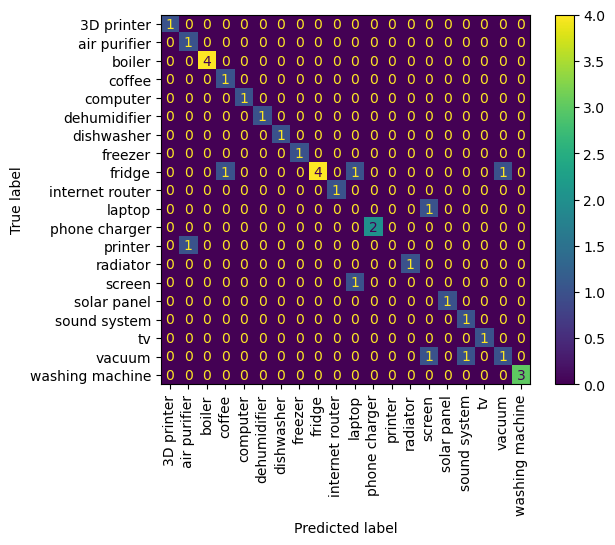

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#use X_pca and y instead

X_train, X_test, y_train, y_test = train_test_split(X_pca, y)

    
#Model complexity

neighbors = range(1, 15, 2)

training_scores = []
test_scores = []
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=13)

for n_neighbors in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    training_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))
    
plt.figure()
plt.plot(neighbors, training_scores, label="training scores")
plt.plot(neighbors, test_scores, label="test scores")
plt.ylabel("accuracy")
plt.xlabel("n_neighbors")
plt.legend()


#Improving the results : Cross validation

from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X_pca, y)
cross_val_scores = []

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    cross_val_scores.append(np.mean(scores))
    
print("best cross-validation score: {:.3f}".format(np.max(cross_val_scores)))
best_n_neighbors = neighbors[np.argmax(cross_val_scores)]
print("best n_neighbors:", best_n_neighbors)

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)
print("test-set score: {:.3f}".format(knn.score(X_test, y_test)))


#Improving again the complexity of the model : GridSearchCV

from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, stratify=y, random_state=42)

param_grid_knn = {'n_neighbors': np.arange(1, 15, 2)}

grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn,
                    cv=10, return_train_score=True)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

import pandas as pd
results = pd.DataFrame(grid.cv_results_)
print(results)

#ploting the results

results.plot('param_n_neighbors', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_n_neighbors.astype(int),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_n_neighbors.astype(int),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()


from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X_pca, y)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(confusion_matrix)

y_label=y_test
for i in range(len(y_pred)):
    if y_pred[i] not in y_label:
        y_label.append(y_pred[i])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels=np.unique(y_label))
cm_display.plot()
plt.xticks(rotation=90)
plt.show()